In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

In [6]:
from torch_geometric import transforms

In [284]:
import torch
from torch import Tensor

from torch_geometric.data import Data
from torch_geometric.transforms import BaseTransform

class MotherNode(BaseTransform):
    def __init__(self, is_real=True, id=1):
        self.is_real = is_real
        self.id = id
        
    def __call__(self, data: Data) -> Data:
        num_nodes, (row, col) = data.num_nodes, data.edge_index
        edge_type = data.get('edge_type', torch.zeros_like(row))
        node_type = data.get('node_type', torch.zeros(num_nodes))

        prev_nodes = node_type == (self.id - 1)

        arange = torch.arange(num_nodes, device=row.device)[prev_nodes]
        num_prev = len(arange)
        
        full = row.new_full((num_prev, ), num_nodes)
        row = torch.cat([row, arange, full], dim=0)
        col = torch.cat([col, full, arange], dim=0)
        edge_index = torch.stack([row, col], dim=0)

        new_type = edge_type.new_full((num_prev, ), self.id)
        edge_type = torch.cat([edge_type, new_type, new_type], dim=0)
        
        new_type = node_type.new_full((1, ), self.id)
        node_type = torch.cat([node_type, new_type], dim=0)

        for key, value in data.items():
            if key == 'edge_index' or key == 'edge_type':
                continue

            if isinstance(value, Tensor):
                dim = data.__cat_dim__(key, value)
                size = list(value.size())

                fill_value = None
                if data.is_edge_attr(key):
                    size[dim] = 2 * num_prev
                    fill_value = 0.
                elif data.is_node_attr(key):
                    size[dim] = 1
                    fill_value = 0.
                elif key == 'y':
                    size[dim] = 1
                    fill_value = 1

                if fill_value is not None:
                    new_value = value.new_full(size, fill_value)
                    data[key] = torch.cat([value, new_value], dim=dim)

        data.edge_index = edge_index
        data.edge_type = edge_type
        data.node_type = node_type

        if 'num_nodes' in data:
            data.num_nodes = data.num_nodes + 1

        return data

In [300]:
template = gnn.Dataset('data/template',make_template=True, transform=gnn.Transform(
    MotherNode(id=1),MotherNode(id=1),MotherNode(id=1),MotherNode(id=1),
    MotherNode(id=2),MotherNode(id=2),
    MotherNode(id=3),
    
    MotherNode(id=1)
    ),scale='standardize')


In [301]:
dataset = gnn.Dataset('data/MX_1200_MY_500-testing',transform=template.transform)

In [302]:
graph = dataset[0]
graph

Data(x=[17, 5], edge_index=[2, 191], edge_attr=[191, 4], y=[17], edge_y=[191], edge_type=[191], node_type=[17])

In [303]:
torch.where(graph.node_type==1)

(tensor([ 9, 10, 11, 12, 16]),)

In [304]:
graph.edge_index[:,(graph.edge_index[0,:] == 8)],(graph.edge_index[0,:] == 8).sum()

(tensor([[ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
         [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 16]]),
 tensor(14))

In [305]:

import networkx as nx
from torch_geometric.utils import to_networkx

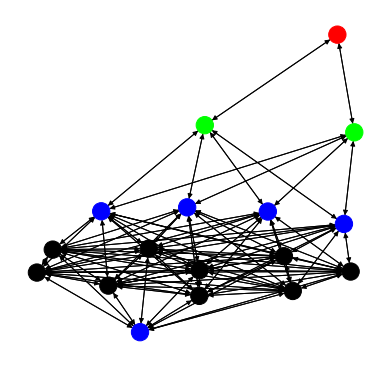

In [307]:
g = to_networkx(graph, remove_self_loops=True)

node_color = list(map({0:(0,0,0),1:(0,0,1),2:(0,1,0),3:(1,0,0)}.get, graph.node_type.numpy().astype(int)))

nx.draw(g,node_color=node_color)

In [308]:

from torch_geometric.loader import DataLoader

training,validation = gnn.train_test_split(dataset,0.99)
print(len(training))

validation, _ = gnn.train_test_split(validation, 0.99)
print(len(validation))
trainloader = DataLoader(training,batch_size=100,shuffle=True,num_workers=16)
validloader = DataLoader(validation,batch_size=100,shuffle=True,num_workers=16)


721
714


In [326]:
model = gnn.GoldenGCN(template)

In [327]:
for batch in trainloader: break

In [328]:
node_o, edge_o = model.predict(batch)

In [329]:
edge_o[batch.edge_type==1]

tensor([0.9793, 0.4861, 0.2955,  ..., 0.9595, 0.6740, 0.1541])

In [336]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

trainer = pl.Trainer(
    max_epochs=10,
    gpus=1 if gnn.config.useGPU else 0,
    # callbacks=[EarlyStopping(monitor="val_loss")],
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [337]:
fit = trainer.fit(model, trainloader, validloader)


  | Name         | Type          | Params
-----------------------------------------------
0 | conv1        | GCNConvMSG    | 480   
1 | relu1        | GCNRelu       | 0     
2 | conv2        | GCNConvMSG    | 20.6 K
3 | relu2        | GCNRelu       | 0     
4 | node_linear1 | NodeLinear    | 8.3 K 
5 | edge_linear1 | EdgeLinear    | 24.6 K
6 | relu3        | GCNRelu       | 0     
7 | node_linear2 | NodeLinear    | 130   
8 | edge_linear2 | EdgeLinear    | 130   
9 | log_softmax  | GCNLogSoftmax | 0     
-----------------------------------------------
54.2 K    Trainable params
0         Non-trainable params
54.2 K    Total params
0.217     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 16/16 [00:05<00:00,  2.98it/s, loss=1.96, v_num=2]


In [339]:
dataset[0].y

tensor([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [338]:
model.predict(dataset[0])

(tensor([0.3875, 0.6452, 0.9214, 0.9119, 0.3542, 0.4355, 0.6190, 0.2318, 0.8667]),
 tensor([0.0066, 0.1947, 0.2393, 0.2617, 0.0772, 0.0503, 0.2178, 0.0533, 0.2259,
         0.2484, 0.6986, 0.3375, 0.5841, 0.1465, 0.0168, 0.3031, 0.0927, 0.5432,
         0.4721, 0.6203, 0.6817, 0.5524, 0.5852, 0.4309, 0.6071, 0.4424, 0.4734,
         0.4335, 0.6333, 0.6312, 0.4851, 0.4800, 0.1981, 0.4063, 0.4076, 0.4731,
         0.1600, 0.3801, 0.5500, 0.3121, 0.1558, 0.1443, 0.3912, 0.0753, 0.2159,
         0.1064, 0.0566, 0.4572, 0.2246, 0.1325, 0.1294, 0.3035, 0.0860, 0.1171,
         0.6122, 0.3418, 0.5392, 0.3391, 0.5021, 0.3229, 0.2521, 0.3886, 0.3429,
         0.1643, 0.2309, 0.3793, 0.1848, 0.1431, 0.0855, 0.2544, 0.0778, 0.1361,
         0.5131, 0.7388, 0.6478, 0.5841, 0.3256, 0.0734, 0.4714, 0.1389, 0.5826]))

In [334]:
model.global_step

8